In [1]:
import torch
import torchvision

from torch.utils.data import DataLoader

from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

#The dataset is in PIL, needs to be Tensors.
transform = transforms.Compose([
    transforms.ToTensor()
])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


c:\Users\Nicolas Ong\Documents\Data2\Python\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 SUPER'

In [3]:
trainset = torchvision.datasets.MNIST(root='C:/Users/Nicolas Ong/Documents/Data2/Datasets/PyTorch', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='C:/Users/Nicolas Ong/Documents/Data2/Datasets/PyTorch', train=False, download=True, transform=transform)

train_dataloader = DataLoader(trainset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
B = 64
C = 1
H = 28
W = 28

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        #define the layers here
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(8)

        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)

        self.linear1 = nn.Linear(8 * 3 * 3, 50)
        self.bn4 = nn.BatchNorm1d(50)
        self.linear2 = nn.Linear(50, 100)
    
    def forward(self, x):
        #defined the forward pass here
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) #28, 14
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) #14, 7
        x = self.pool(F.relu(self.bn3(self.conv3(x)))) #7, 3
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn4(self.linear1(x)))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        #define the layers here
        #I'll start with a Linear decoder for now. Then do a "transposed convolutional" one later.
        self.linear1 = nn.Linear(50, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.linear2 = nn.Linear(100, 300)
        self.bn2 = nn.BatchNorm1d(300)
        self.linear3 = nn.Linear(300, 784)

        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        #defined the forward pass here
        x = F.relu(self.bn1(self.linear1(x)))
        x = F.relu(self.bn2(self.linear2(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.linear3(x))
        x = x.reshape(-1, 1, 28, 28)
        return x

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_params = self.encoder(x)
        
        # Split the tensor into two equal parts for means and standard deviations
        means = latent_params[:, :50]
        logvars = latent_params[:, 50:]
        
        # Sample epsilon from the standard Gaussian distribution
        stds = torch.exp(0.5 * logvars)
        epsilon = torch.randn_like(means)

        # Perform the reparameterization trick to obtain the latent vector
        latent_vector = means + stds * epsilon
        
        x = self.decoder(latent_vector)
        return x, means, logvars

In [5]:
#From: https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb
input_dim  = 784
hidden_dim = 400
latent_dim = 200
output_dim  = 784

class EncoderAlt(nn.Module):
    def __init__(self):
        super().__init__()
        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = x.reshape(-1, 784)
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)
        return mean, log_var

class DecoderAlt(nn.Module):
    def __init__(self):
        super().__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        x = x_hat.reshape(-1, 1, 28, 28)
        return x

class VAEAlt(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        means, logvars = self.encoder(x)
        
        # Sample epsilon from the standard Gaussian distribution
        stds = torch.exp(0.5 * logvars)
        epsilon = torch.randn_like(means)

        # Perform the reparameterization trick to obtain the latent vector
        latent_vector = means + stds * epsilon
        
        x = self.decoder(latent_vector)
        return x, means, logvars

In [6]:
net = VAE()
net.to(device)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.25, inplace=False)
    (linear1): Linear(in_features=72, out_features=50, bias=True)
    (bn4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear2): Linear(in_features=50, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=50, out_features=100, bias=True)
    (bn1): Batch

In [7]:
'''
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs, mean, stds = net(inputs)
        print(KLDivergenceLoss(mean, stds))
        print(reconstructionLoss(inputs, outputs))
        break
'''

'\ncorrect = 0\ntotal = 0\nwith torch.no_grad():\n    for data in test_dataloader:\n        inputs, labels = data[0].to(device), data[1].to(device)\n        outputs, mean, stds = net(inputs)\n        print(KLDivergenceLoss(mean, stds))\n        print(reconstructionLoss(inputs, outputs))\n        break\n'

In [8]:
reconstructionLoss = nn.MSELoss(reduction="sum")

def KLDivergenceLoss(mu, logvar):
    # KL-Divergence loss (regularization term)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl_loss

def totalloss(inputs, outputs, mu, logvar):
    a = 1
    b = 1
    return (a * reconstructionLoss(inputs, outputs)) + (b * KLDivergenceLoss(mu, logvar))

optimizer = optimizer = torch.optim.AdamW(net.parameters(), lr=0.001)

In [9]:
total_parameters = count_parameters(net)
print(f"Total number of parameters: {total_parameters}")

Total number of parameters: 287250


In [10]:
x_batch = []
x_batch_500 = []
train_rloss_list = []
train_kl_list = []
test_rloss_list = []
test_kl_list = []
cur_iter = -1

In [ ]:
net.train()
for epoch in range(15):
    for i, data in enumerate(train_dataloader):
        cur_iter += 1
        x_batch.append(cur_iter)

        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs, means, logvars = net(inputs)
        loss = totalloss(inputs, outputs, means, logvars)
        loss.backward()
        optimizer.step()

        # Reconstruction and KL loss for the current batch
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item() :.3f}')
        train_rloss_list.append(reconstructionLoss(inputs, outputs).item())
        train_kl_list.append(KLDivergenceLoss(means, logvars).item())

        #validation loss and model accuracy for the entire test dataset - every 500 batches
        if (i % 500 == 499):
            x_batch_500.append(cur_iter)
            running_rloss = 0
            running_klloss = 0
            iterations = 0
            with torch.no_grad():
                for data in test_dataloader:
                    inputs, labels = data[0].to(device), data[1].to(device)
                    outputs, means, logvars = net(inputs)

                    running_rloss += reconstructionLoss(inputs, outputs).item()
                    running_klloss += KLDivergenceLoss(means, logvars).item()
                    iterations += 1
            test_rloss_list.append(running_rloss/iterations)
            test_kl_list.append(running_klloss/iterations)

In [12]:
f1 = go.Figure(
    data = [
        go.Scatter(x=x_batch, y=train_rloss_list, name="training Reconstruction loss"),
        go.Scatter(x=x_batch, y=train_kl_list, name="training KL-divergence loss"),
        go.Scatter(x=x_batch_500, y=test_rloss_list, name="test Reconstruction loss"),
        go.Scatter(x=x_batch_500, y=test_kl_list, name="test KL-divergence loss"),
    ],
    layout = {"xaxis": {"title": "Iterations"}, "yaxis": {"title": "y axis"}, "title": "Loss/Accuracy", "width": 800, "height": 600}
)
f1

In [13]:
net.eval()
running_rloss = 0
running_klloss = 0
iterations = 0
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs, means, logvars = net(inputs)

        running_rloss += reconstructionLoss(inputs, outputs).item()
        running_klloss += KLDivergenceLoss(means, logvars).item()
        iterations += 1
print(running_rloss/iterations)
print(running_klloss/iterations)

1715.8210958492984
412.6194278206795


In [14]:
net.eval()
running_rloss = 0
running_klloss = 0
iterations = 0
with torch.no_grad():
    for data in train_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs, means, logvars = net(inputs)

        running_rloss += reconstructionLoss(inputs, outputs).item()
        running_klloss += KLDivergenceLoss(means, logvars).item()
        iterations += 1
print(running_rloss/iterations)
print(running_klloss/iterations)

1736.825048711
412.7741298553532


In [15]:
#torch.save(net, '2023-04-06 02 CNN 10K weights.pth')

In [16]:
def displayBatch(images):
    # Remove the extra dimension
    images = images.cpu().squeeze(1)

    # Calculate the number of rows and columns for the grid
    n_rows = int(np.sqrt(images.shape[0]))
    n_cols = n_rows

    # Plot the images
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    for i in range(n_rows):
        for j in range(n_cols):
            axs[i, j].imshow(images[i * n_cols + j], cmap='gray')
            axs[i, j].axis('off')

    plt.show()

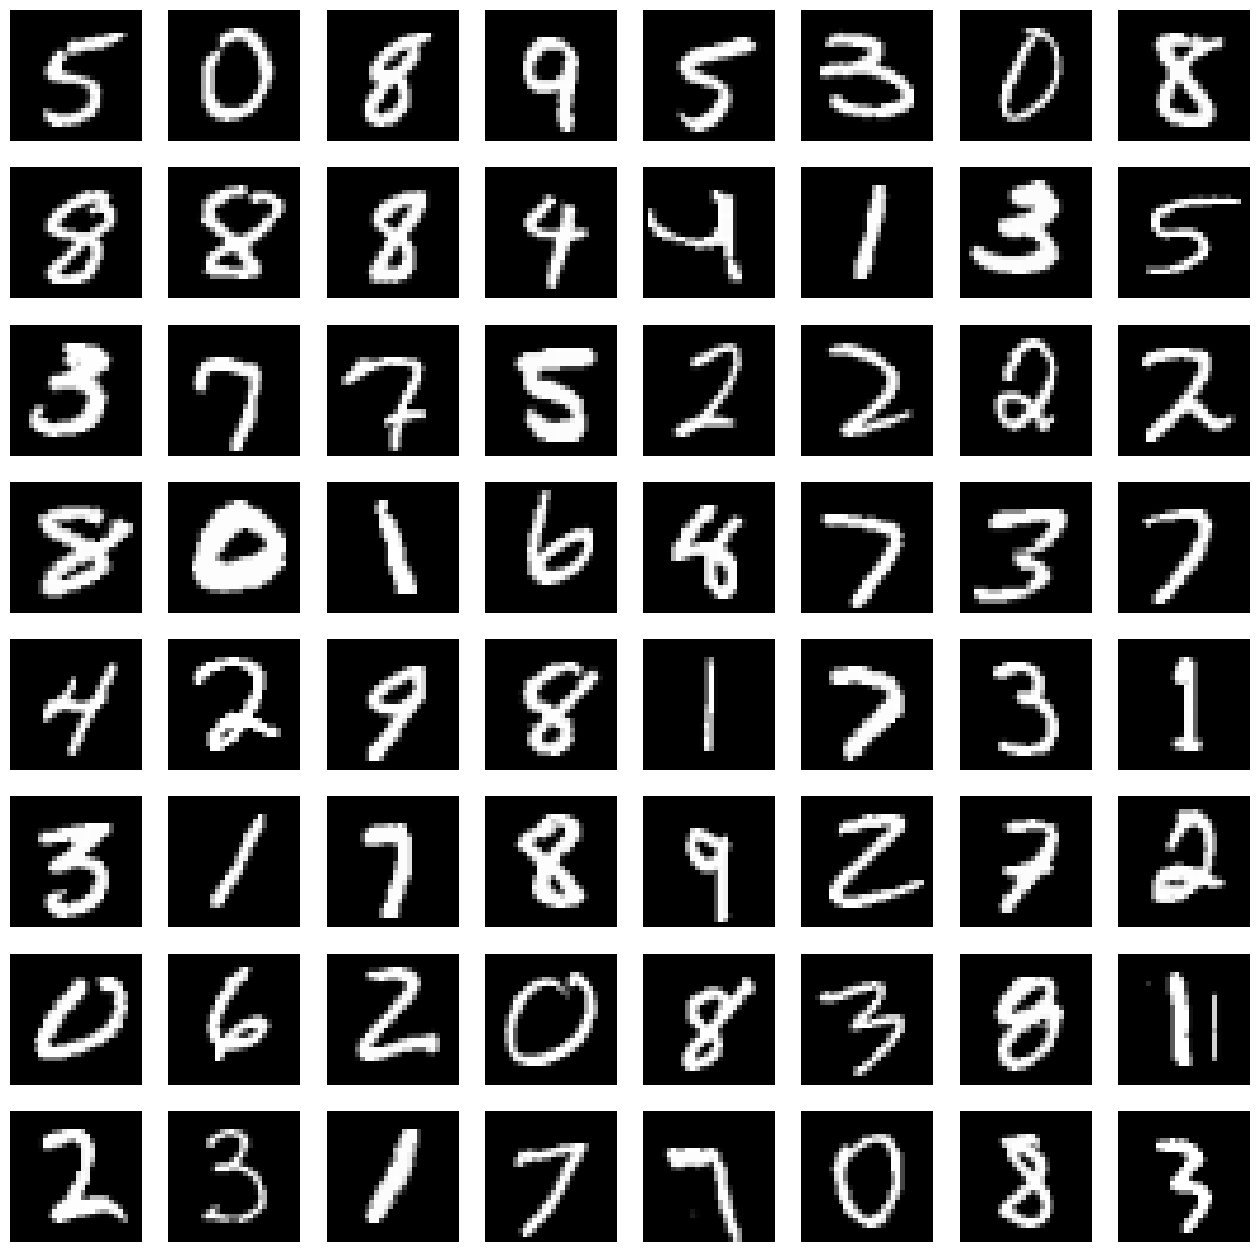

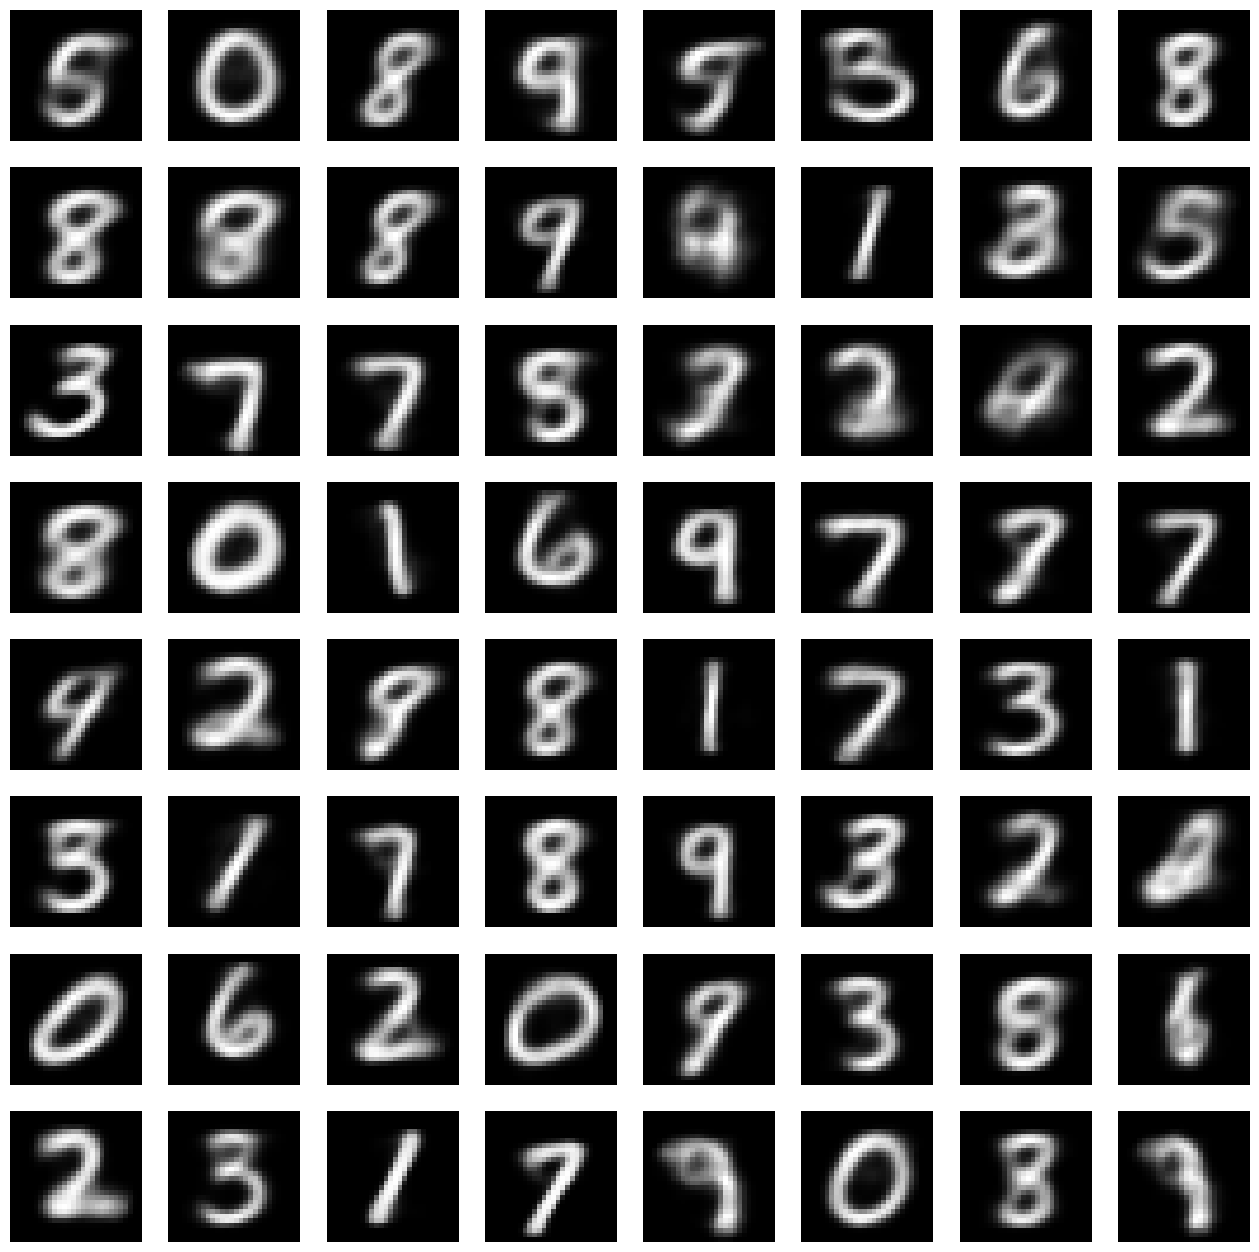

In [17]:
net.eval()
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device)

        displayBatch(inputs)
        
        outputs, means, logvars = net(inputs)
        displayBatch(outputs)

        break

torch.Size([64, 1, 28, 28])


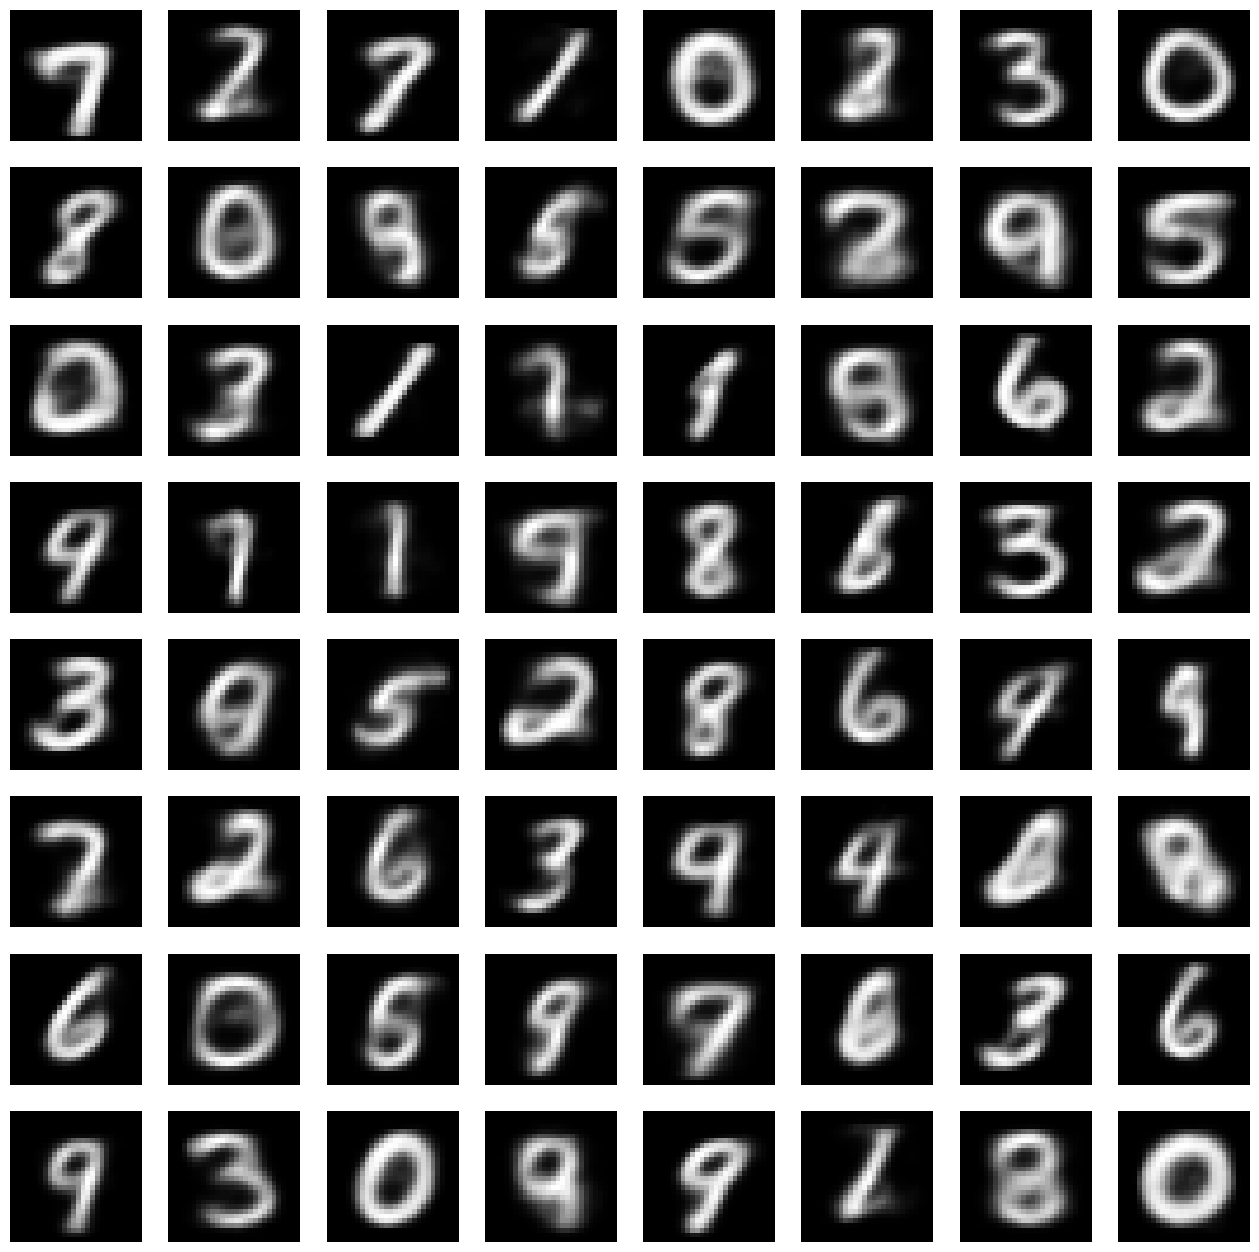

In [18]:
latent_dim = 50  # Example for a VAE with a latent dimension of 50
z = torch.randn(64, latent_dim)  # Sample a single latent vector from the prior distribution
with torch.no_grad():  # Disable gradient computation
    net.eval()  # Set the VAE model to evaluation mode
    net.cpu()
    generated_image = net.decoder(z)  # Pass the sampled latent vector through the decoder
    print(generated_image.shape)
    displayBatch(generated_image)

torch.Size([64, 1, 28, 28])


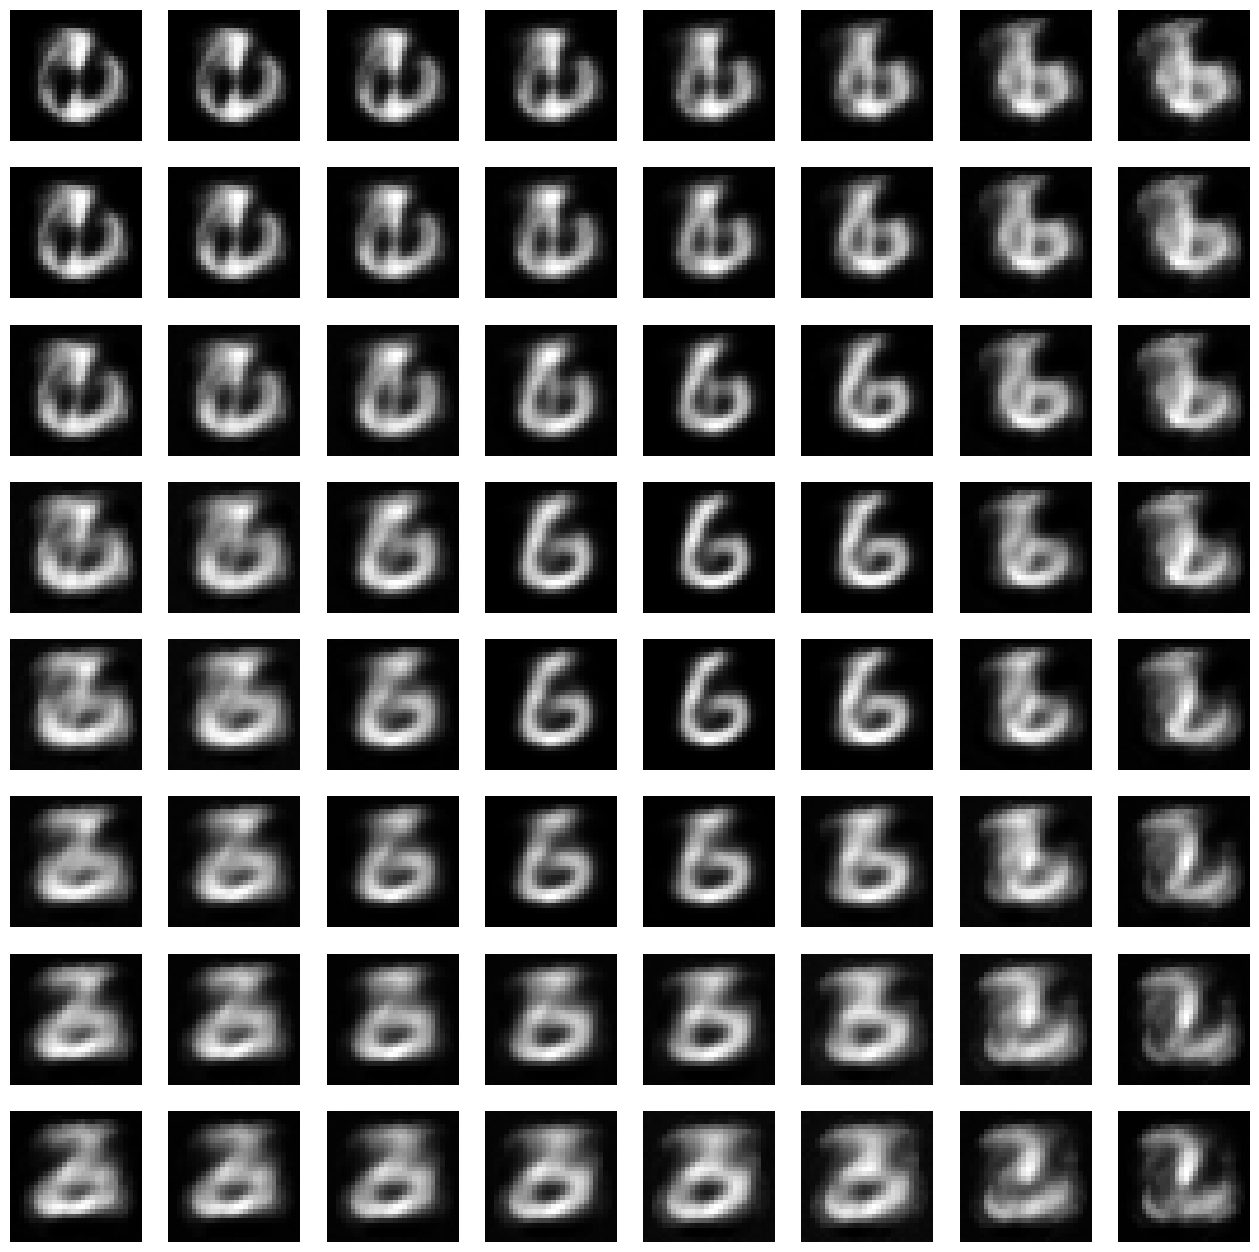

In [24]:
#2 dim grid - where two of the latent dims are altered.

latent_dim = 50  # Example for a VAE with a latent dimension of 20
grid_size = 8
dim1, dim2 = 0, 1  # Indices of the two latent dimensions to alter
variance = 200  # Controls the range of variation along each latent dimension

# Sample a single latent vector from the prior distribution
z_base = torch.randn(1, latent_dim)

# Generate the (64, latent_dim) tensor containing the 64 modified latent vectors
z_tensor = torch.zeros((grid_size * grid_size, latent_dim))
for i in range(grid_size):
    for j in range(grid_size):
        idx = i * grid_size + j
        z = z_base.clone()
        z[0, dim1] += (i - grid_size // 2) * variance / (grid_size - 1)
        z[0, dim2] += (j - grid_size // 2) * variance / (grid_size - 1)
        z_tensor[idx] = z

with torch.no_grad():
    net.eval()
    net.cpu()
    generated_image = net.decoder(z_tensor)  # Pass the sampled latent vector through the decoder
    print(generated_image.shape)
    displayBatch(generated_image)

torch.Size([64, 1, 28, 28])


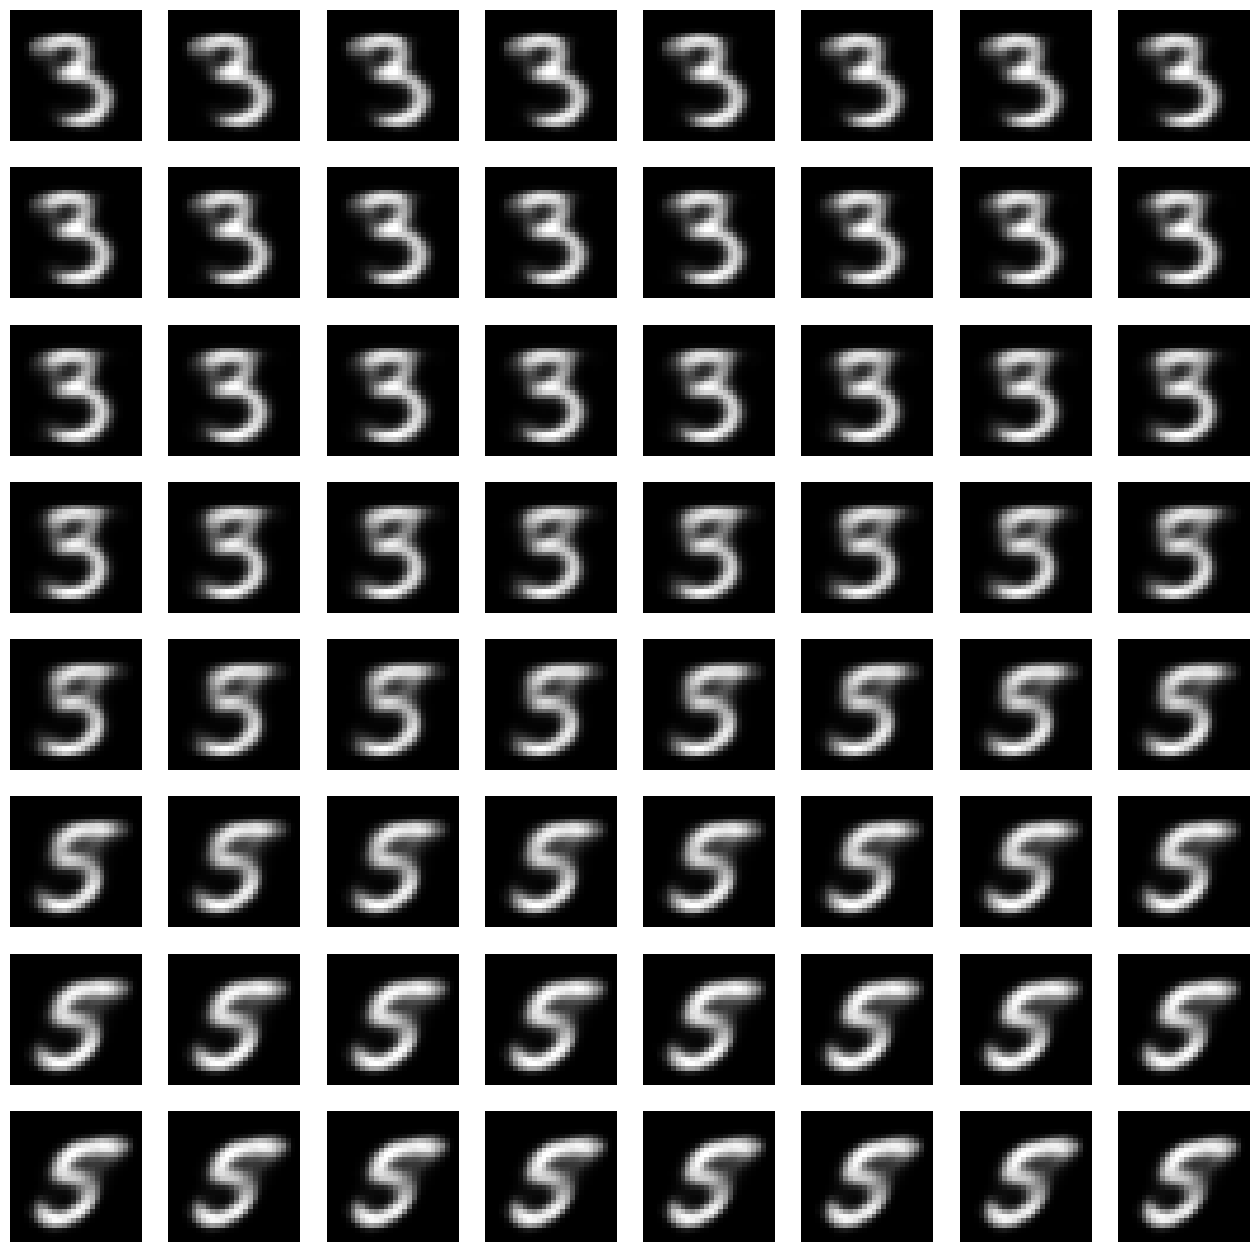

In [40]:
latent_dim = 50  # Example for a VAE with a latent dimension of 20
num_samples = 64  # Number of interpolated samples

# Sample two random latent vectors from the prior distribution
z_start = torch.randn(1, latent_dim)
z_end = torch.randn(1, latent_dim)

# Create the (64, latent_dim) tensor containing the 64 interpolated latent vectors
interpolation_factors = torch.linspace(0, 1, num_samples).view(-1, 1)
z_interpolated = z_start * (1 - interpolation_factors) + z_end * interpolation_factors

with torch.no_grad():
    net.eval()
    net.cpu()
    generated_image = net.decoder(z_interpolated)  # Pass the sampled latent vector through the decoder
    print(generated_image.shape)
    displayBatch(generated_image)
